In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize

import pose

In [126]:
STARFISH_LINES = [[0,1], [0,2], [0,3], [0,4], [0,5]]

# Example line connections
LINES_HAND = [[0,1],[1,2],[2,3],[3,4], 
            [0,5],[5,6],[6,7],[7,8],
            [5,9],[9,10],[10,11],[11,12],
            [9,13],[13,14],[14,15],[15,16],
            [13,17],[17,18],[18,19],[19,20],[0,17]]

# world_landmarks = np.array([[0.02374268,  0.08691406,  0.00775146], # flat hand
#  [ 0.04437256,  0.05322266,  0.0010376 ],
#  [ 0.05435181,  0.02783203, -0.00985718],
#  [ 0.06225586, -0.00268555, -0.02325439],
#  [ 0.06652832, -0.02709961, -0.02154541],
#  [ 0.02354431, -0.01275635,  0.0012207 ],
#  [ 0.01716614, -0.03955078, -0.00231934],
#  [ 0.01314545, -0.05871582, -0.01324463],
#  [ 0.01177216, -0.07482910, -0.04034424],
#  [ 0.00268555, -0.00598145,  0.00209045],
#  [-0.00336647, -0.03674316, -0.00219727],
#  [-0.00463867, -0.06225586, -0.02017212],
#  [-0.00500488, -0.07977295, -0.04547119],
#  [-0.01699829,  0.00622559, -0.00180054],
#  [-0.02333069, -0.02276611, -0.00952148],
#  [-0.02537537, -0.04528809, -0.02410889],
#  [-0.02499390, -0.06634521, -0.04180908],
#  [-0.02635193,  0.02539062, -0.01043701],
#  [-0.04098511,  0.00578308, -0.01611328],
#  [-0.04727173, -0.01223755, -0.02810669],
#  [-0.04705811, -0.02474976, -0.0435791 ]])

world_landmarks = np.array([[-0.00744629,  0.07958984,  0.05474854], # closed (not fully)
 [ 0.02064514,  0.05786133,  0.03277588],
 [ 0.03594971,  0.04211426,  0.00765991],
 [ 0.04766846,  0.02563477, -0.02746582],
 [ 0.05764771,  0.00891113, -0.04669189],
 [ 0.02729797, -0.00531006, -0.00030518],
 [ 0.03117371, -0.03002930, -0.01303101],
 [ 0.03353882, -0.04699707, -0.02761841],
 [ 0.03613281, -0.05847168, -0.05865479],
 [ 0.00489807, -0.00646973,  0.0       ],
 [ 0.00433731, -0.03796387, -0.00582886],
 [ 0.00579834, -0.06115723, -0.02328491],
 [ 0.01037598, -0.07806396, -0.05487061],
 [-0.01730347,  0.00210571,  0.00053406],
 [-0.02194214, -0.02532959, -0.01220703],
 [-0.02136230, -0.04602051, -0.03497314],
 [-0.01646423, -0.06414795, -0.06213379],
 [-0.03524780,  0.02026367, -0.00073242],
 [-0.04708862,  0.00370789, -0.01138306],
 [-0.05065918, -0.00814819, -0.03103638],
 [-0.04772949, -0.01484680, -0.05511475]])

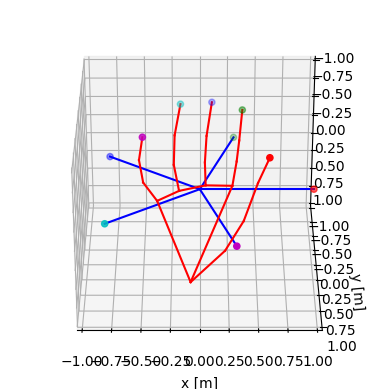

In [127]:
hand = pose.Pose(LINES_HAND, world_landmarks)
hand.normalize()

starfish = pose.Pose(STARFISH_LINES, pose.starfish_pose(0))

matches = starfish.get_matches(hand.end_effectors_world())

ax = plt.figure().add_subplot(projection='3d')
starfish.draw_pose(ax,starfish.end_effectors)
hand.draw_pose(ax,hand.end_effectors,link_color='r',elev=30)
plt.show()

In [128]:
# Cost of an agent pose given an expert pose
# use the x,y plane to match joints
# use z error as cost
def cost_func(x, expert, agent, matching_points, joint_history, error_history):

    agent.key_points = pose.starfish_pose(x)
    # matching_points = starfish.get_matches(hand.end_effectors_world())

    n = len(agent.key_points)
    m = len(expert.key_points)
    
    err = np.zeros(n)

    for (i, j) in enumerate(matching_points):
        if (j >= 0):
            err[i] = np.linalg.norm(expert.key_points[expert.end_effectors[j],:] - agent.key_points[i,:])
    
    joint_history.append(x)
    error_history.append(err)

    return np.sum(err)

In [134]:
error = []
starfish_joints = []
sol = minimize(cost_func, [np.pi/2, 0, 0, 0, 0], (hand, starfish, matches, starfish_joints, error), method='Powell', bounds=[[-np.pi/2,np.pi/2] for _ in range(5)])

draw_match = []
for i in range(len(matches)):
    if matches[i] >= 0:
        draw_match.append(i+1)

print(f"Matches: {matches}\nSolution:\n{sol}")

Matches: [0 2 3 4 0]
Solution:
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 3.18142467194797
       x: [-1.384e+00 -8.380e-01 -8.611e-01 -1.571e+00  1.571e+00]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 150


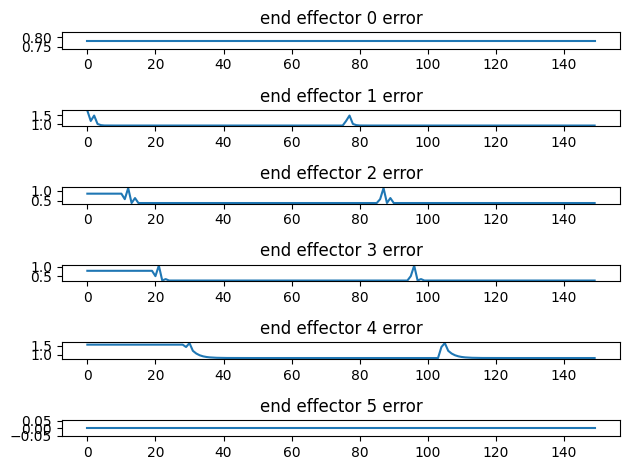

In [135]:
error = np.array(error)

for i in range(error.shape[1]):
    plt.subplot(error.shape[1],1,i+1)
    plt.plot(range(len(error)), error[:,i])
    plt.title(f"end effector {i} error")

plt.tight_layout()
plt.show()

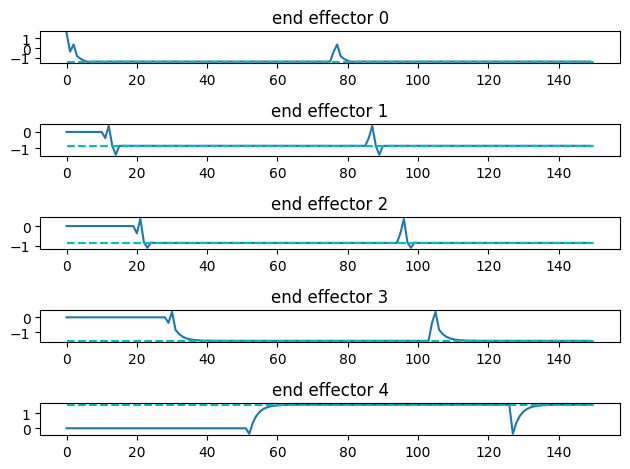

In [136]:
starfish_joints = np.array(starfish_joints)

for i in range(starfish_joints.shape[1]):
    plt.subplot(starfish_joints.shape[1],1,i+1)
    plt.plot(range(len(starfish_joints)), starfish_joints[:,i])
    plt.plot([0,len(starfish_joints)], [sol.x[i], sol.x[i]], 'c--')
    plt.title(f"end effector {i}")

plt.tight_layout()
plt.show()

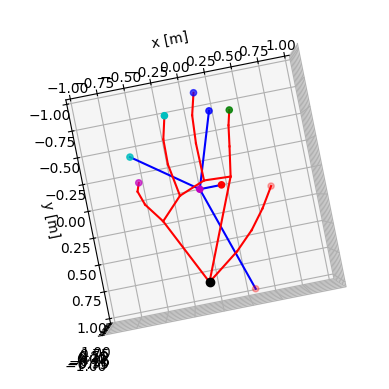

In [133]:
starfish.key_points = pose.starfish_pose(sol.x)

ax = plt.figure().add_subplot(projection='3d')
starfish.draw_pose(ax, draw_match, joint_color=pose.DRAWING_COLORS[matches[matches>=0]%len(pose.DRAWING_COLORS)])
hand.draw_pose(ax, hand.end_effectors, link_color='r', elev=90, azim=15, base=1)
plt.show()

In [34]:
print(error.shape[1])

6
